## Data processing construction example using CrossAI 

#### Disable Warnings

In [1]:
import warnings
warnings.filterwarnings('ignore')

#### Import Configuration Module

In [2]:
import yaml

#### Load configuration

In [3]:
with open("../config.yml", "r") as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

#### Load Data
Store into a dataframe which will contain all data and the respective class label (which is stored in the last column of the dataframe)

In [4]:
data_dir_path = config['PATH']['RAW']['MINI_SPEECH_COMMANDS'] # store to dataframe
SAMPLE_RATE = 16000

In [5]:
from crossai.loader import audio_loader

# All signals are resampled at `SAMPLE_RATE` and normalised (0, 1)
df = audio_loader(path=data_dir_path, sr=SAMPLE_RATE)

Loaded data into the dataframe: 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]                                                   


Create a crossai audio object which will be used for the exploitation of the data processing pipeline.

cai_audio.data holds the data in a dataframe: each row/signal is np.float32  
and cai_audio.lalbels holds the data labels in a dataframe

In [6]:
from crossai.pipelines.audio import Audio

cai_audio = Audio(df)
cai_audio.data.head()

0    [0.506821, 0.50676304, 0.50670505, 0.5071688, ...
1    [0.53376144, 0.5336966, 0.5336966, 0.5336966, ...
2    [0.6036141, 0.6044156, 0.6044885, 0.6037598, 0...
3    [0.4621682, 0.45547011, 0.4510047, 0.44058546,...
4    [0.5535465, 0.5521018, 0.55163574, 0.5524979, ...
Name: data, dtype: object

In [7]:
cai_audio.labels.head(), cai_audio.labels.value_counts()

(0    left
 1    left
 2    left
 3    left
 4    left
 Name: label, dtype: object,
 label
 left     1000
 go       1000
 right    1000
 up       1000
 stop     1000
 yes      1000
 down     1000
 no       1000
 Name: count, dtype: int64)

#### Pipeline Construction
- Pad the audio data
- Apply band-pass filtering
- Normalise to (,)
- Convert to df

In [8]:
from crossai.pipelines.timeseries import PadOrTrim

pad_or_trim = PadOrTrim(fill_value=0, pad_type='mean')

Create custom functions for data processing , either 1D or 2D and generate their respective pipeline transformers.

In [10]:
from crossai.pipelines.timeseries import Transformer
from crossai.processing.filter import butterworth_filter

butterworth = Transformer(
    butterworth_filter, 
    f_type='bp', 
    sr=SAMPLE_RATE, 
    cutoff_low=300, 
    cutoff_high=3400, 
    order=6
)

Create a scaler object

In [11]:
from sklearn.preprocessing import StandardScaler
from crossai.pipelines.preparation import Scaler
standard_scaler = Scaler(StandardScaler())

Fit and transform crossai audio data using the transformers.

Finalize Pipeline is used to transform the data back to pandas-series form.

In [12]:
from sklearn.pipeline import Pipeline
from crossai.pipelines.timeseries import ToPandas

pipe = Pipeline([
    ('pd', pad_or_trim),
    ('Scaler', standard_scaler), # allready noramlized, illustration purposes only
    ('Filter', butterworth),
    ('ToPandas', ToPandas())
])
pipe.fit_transform(cai_audio)

Now the cai_audio data object is transformed through the processing pipeline

#### Transform the data from CrossAI object to NumPy array for sklearn model insertion

In [13]:
from crossai.processing import convert_to_model_shape

In [14]:
X = convert_to_model_shape(cai_audio.data, model_cat="statistical")
X.shape

(8000, 15740)

In [15]:
y = cai_audio.labels
y.shape

(8000,)

#### Split dataset on train-test for training and evaluation

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#### Train an SVC 

In [18]:
from sklearn.svm import SVC

clf = SVC(gamma='auto')
clf.fit(X_train, y_train)

SVC(gamma='auto')

#### Predictions on test set

In [19]:
predictions = clf.predict(X_test)

#### Confusion Matrix

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [21]:
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)

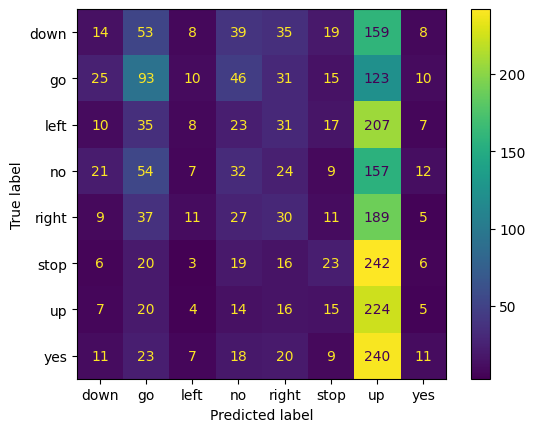

In [22]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

#### Classification Report

In [23]:
from sklearn.metrics import classification_report

In [24]:
print(classification_report(y_test, predictions, target_names=clf.classes_))

              precision    recall  f1-score   support

        down       0.14      0.04      0.06       335
          go       0.28      0.26      0.27       353
        left       0.14      0.02      0.04       338
          no       0.15      0.10      0.12       316
       right       0.15      0.09      0.11       319
        stop       0.19      0.07      0.10       335
          up       0.15      0.73      0.24       305
         yes       0.17      0.03      0.05       339

    accuracy                           0.16      2640
   macro avg       0.17      0.17      0.13      2640
weighted avg       0.17      0.16      0.13      2640

